# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [10]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9913 / 11441 MB available


In [34]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel (float *c, float *a, float *b, int cols)
{
    unsigned int i = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y * blockDim.y + threadIdx.y;
    unsigned int k = i * cols + j;
    c[k] = a[k] + b[k]; 
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel")

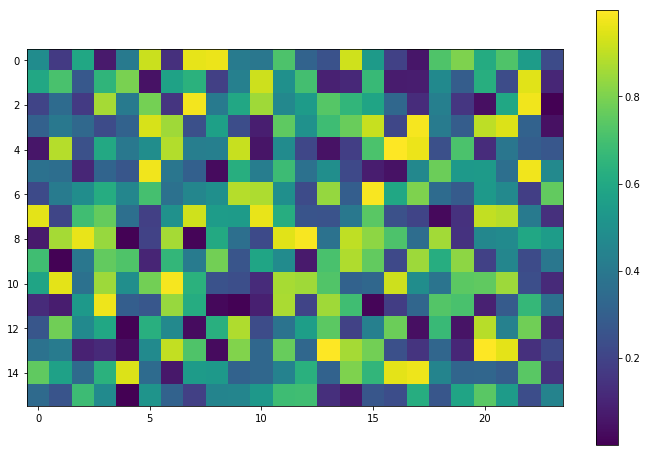

In [35]:
#Size of our test
test_size = (16, 24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12, 8))
plt.imshow(a)
plt.colorbar()

In [50]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

#Allocate output data
c_g = GPUArray(c.shape, np.float32)

domain_size = (a.shape[1], a.shape[0])
block_size = (8, 8, 1)
grid_size = (domain_size[0]//block_size[0], domain_size[1]//block_size[1], 1)
cols = a.shape[0]

print(domain_size)
print(block_size)
print(grid_size)
print(cols)

(24, 16)
(8, 8, 1)
(3, 2, 1)
16


In [51]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(cols),  block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.61602485, 0.5174314 , 1.0868479 , 0.6577917 , 0.5533465 ,
        0.9700928 , 0.34828126, 1.0556675 , 1.0830595 , 0.95298994,
        1.3376565 , 1.0147327 , 1.1835006 , 0.27501073, 1.4492338 ,
        1.0428112 , 0.22811013, 0.73472303, 1.1508024 , 1.1881907 ,
        0.8742614 , 1.350493  , 1.0063798 , 1.0383741 ],
       [0.883043  , 1.1227876 , 0.4174173 , 0.7628869 , 0.97269636,
        0.24104139, 1.0111315 , 1.4775896 , 0.80276597, 1.0565176 ,
        1.1820503 , 1.2938508 , 1.6966854 , 0.9850567 , 0.8463645 ,
        1.29859   , 0.743497  , 0.54026467, 0.5574157 , 1.234001  ,
        0.8587727 , 0.5629158 , 1.3257258 , 0.98269117],
       [1.0896237 , 0.99765253, 0.35571373, 1.6612515 , 0.59635556,
        1.3667991 , 0.53844655, 1.5676129 , 1.2135307 , 1.4889644 ,
        1.4630235 , 0.83043987, 1.4176385 , 1.2465644 , 1.6411847 ,
        0.9744327 , 0.9543791 , 0.25363106, 1.063647  , 1.0919931 ,
        0.86855745, 1.3979919 , 1.2965169 , 0.4539203 ],
       [0.837

In [52]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.61602485 0.5174314  1.0868479  0.6577917  0.5533465  0.9700928
  0.34828126 1.0556675  1.0830595  0.95298994 1.3376565  1.0147327
  1.1835006  0.27501073 1.4492338  1.0428112  0.22811013 0.73472303
  1.1508024  1.1881907  0.8742614  1.350493   1.0063798  1.0383741 ]
 [0.883043   1.1227876  0.4174173  0.7628869  0.97269636 0.24104139
  1.0111315  1.4775896  0.80276597 1.0565176  1.1820503  1.2938508
  1.6966854  0.9850567  0.8463645  1.29859    0.743497   0.54026467
  0.5574157  1.234001   0.8587727  0.5629158  1.3257258  0.98269117]
 [1.0896237  0.99765253 0.35571373 1.6612515  0.59635556 1.3667991
  0.53844655 1.5676129  1.2135307  1.4889644  1.4630235  0.83043987
  1.4176385  1.2465644  1.6411847  0.9744327  0.9543791  0.25363106
  1.063647   1.0919931  0.86855745 1.3979919  1.2965169  0.4539203 ]
 [0.8373741  1.0291779  0.4623887  0.64259154 0.40326992 1.85813
  1.3471801  1.1024214  0.7747101  0.6404281  0.57490885 1.6582139
  0.58862996 1.6669315  1.624382   1.6146929  

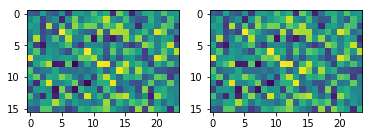

In [53]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)